# Analysis of Preprint Papers from the ArXiv

The website [arxiv.org](https://arxiv.org) is a popular database for scientific papers in STEM fields. ArXiv has its own classification system consisting of roughly 150 different categories, which are manually added by the authors whenever a new paper is uploaded. A paper can be assigned multiple categories.

The goal for this project is to develop a machine learning model which can predict the ArXiv category from a given title and abstract.

We start by importing all the packages we will need and setting up a data directory.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # used for handling files
from sklearn.decomposition import PCA # dimension reduction of data
import pickle # saving models
from pathlib import Path # to get home directory
from functools import reduce # used to calculate accuracy of model

# local files
import arxiv_scraper
import cleaner
import elmo
import NN
import onehot

print("Packages loaded.")

Packages loaded.


The data set used here has been scraped from the [ArXiv API](https://arxiv.org/help/api) over several days, using the Python scraper `arxiv_scraper.py`. To get a sense for how long the scraping takes, you can uncomment and run the script below.

In [2]:
#arxiv_scraper.cat_scrape(
#    max_results_per_cat = 100, # maximum number of papers to download per category (there are ~150 categories)
#    file_path = "arxiv_data", # name of output file
#    batch_size = 100 # size of every batch - lower batch size requires less memory - must be less than 30,000
#)

Alternatively, I have downloaded metadata from about a million papers using this scraper (with `max_results_per_cat` = 10000), which can be freely downloaded below. This data set takes up ~1gb of space, however, so I've included many random samples of this data set as well:

* `arxiv` contains the main data set
* `arxiv_sample_1000` contains 1,000 papers
* `arxiv_sample_5000` contains 5,000 papers
* `arxiv_sample_10000` contains 10,000 papers
* `arxiv_sample_25000` contains 25,000 papers
* `arxiv_sample_50000` contains 50,000 papers
* `arxiv_sample_100000` contains 100,000 papers
* `arxiv_sample_200000` contains 200,000 papers
* `arxiv_sample_500000` contains 500,000 papers
* `arxiv_sample_750000` contains 750,000 papers

Choose your favorite below. Alternatively, of course, you can set it to be the file name of your own scraped data.

In [2]:
file_name = "arxiv_sample_100000"

Next up, we specify the folder in which we will store all our data. Change to whatever folder you would like.

In [3]:
home_dir = str(Path.home())
data_path = os.path.join(home_dir, "pCloudDrive", "public_folder", "scholarly_data")

## Fetching data

We then do some basic setting up.

In [8]:
# create path directory and download a list of all arXiv categories
cleaner.setup(data_path)

# download the raw titles and abstracts
cleaner.download_papers(file_name, data_path)

cats.csv is already downloaded.
arxiv_val_set.csv is already downloaded.
arxiv_sample_100000.csv is already downloaded.


Next, we store the list of arXiv categories.

In [4]:
# construct category dataframe and array
full_path = os.path.join(data_path, "cats.csv")
cats_df = pd.read_csv(full_path)
cats = np.asarray(cats_df['category'].values)

pd.set_option('display.max_colwidth', 50)
cats_df.head()

,category,description
0,astro-ph,Astrophysics
1,astro-ph.CO,Cosmology and Nongalactic Astrophysics
2,astro-ph.EP,Earth and Planetary Astrophysics
3,astro-ph.GA,Astrophysics of Galaxies
4,astro-ph.HE,High Energy Astrophysical Phenomena


## Cleaning the data

We now do some basic cleaning operations on our raw data. We convert strings '\[cat_1, cat_2\]' into actual lists \[cat_1, cat_2\], make everything lower case, removing punctuation, numbers and whitespace, and dropping NaN rows.

Our last text cleaning step is to lemmatise the text, which reduces all words to its base form. For instance, 'eating' is converted into 'eat' and 'better' is converted into 'good'. This usually takes a while to finish, so instead we're simply going to download a lemmatised version of your chosen data set. Alternatively, if you're dealing with your own scraped data set, you can uncomment the marked lines below.

In [10]:
full_path = os.path.join(data_path, f"{file_name}_clean.csv")
if not os.path.isfile(full_path):
    # preclean raw data and save the precleaned texts and
    # categories to {file_name}_preclean.csv
    cleaner.get_preclean_text(file_name, data_path)

    # lemmatise precleaned data and save lemmatised texts to 
    # {file_name}_clean.csv and delete the precleaned file
    cleaner.lemmatise_file(file_name, batch_size = 1000, path = data_path, confirmation = False)

# load in cleaned text
print("Loading cleaned text...")
full_path = os.path.join(data_path, f"{file_name}_clean.csv")
clean_text = pd.read_csv(full_path, delimiter = '\n', header = None)
clean_df = pd.DataFrame(clean_text)
clean_df.columns = ['clean_text']

# load in cats and add them to df
full_path = os.path.join(data_path, f"{file_name}_cats.csv")
clean_cats_with_path = lambda x: cleaner.clean_cats(x, path = data_path)
cleaned_cats = pd.read_csv(full_path, header = None, converters = {0 : clean_cats_with_path})

# join the two dataframes
clean_df['category'] = cleaned_cats.iloc[:, 0]

print(f"Shape of clean_df: {clean_df.shape}. Here are some of the lemmatised texts:")
pd.set_option('display.max_colwidth', 1000)
clean_df[['clean_text', 'category']].head()

Loading cleaned text...
Shape of clean_df: (99998, 2). Here are some of the lemmatised texts:


,clean_text,category
0,"distribution define by q - supernomial , fusion product , and demazure module -PRON- prove asymptotic normality of the distribution define by q - supernomial , which imply asymptotic normality of the distribution give by the central string function and the basic specialization of fusion module of the current algebra of sl . the limit be take over linearly scale fusion power of a fix collection of irreducible representation . this include as special instance all demazure module of the affine kac - moody algebra associate to sl . along with an available complementary result on the asymptotic normality of the basic specialization of graded tensor of the type a standard representation , -PRON- result be a central limit theorem for a serious class of graded tensor . -PRON- therefore serve as an indication towards universal behavior : the central string function and the basic specialization of fusion and , in particular , demazure module behave asymptotically normal , as the number of fu...","[math.CO, math.RT]"
1,gravitational lensing by eigenvalue distribution of random matrix model -PRON- propose to use eigenvalue density of unitary random matrix ensemble as mass distribution in gravitational lensing . the corresponding lens equation reduce to algebraic equation in the complex plane which can be treat analytically . -PRON- prove that these model can be apply to describe lense by system of edge - on galaxy . -PRON- illustrate -PRON- analysis with the gaussian and the quartic unitary matrix ensemble .,"[math-ph, math.MP]"
2,"on exel - pardo algebra -PRON- generalize a recent construction of exel and pardo , from discrete group act on finite direct graph to locally compact group act on topological graph . to each cocycle for such an action , -PRON- construct a $ c^*$-correspondence whose associate cuntz - pimsner algebra be the analog of the exel - pardo $ c^*$-algebra .",[math.OA]
3,"legendrian submanifold from bohr - sommerfeld cover of monotone lagrangian tori by a result due to ziltener , there exist no closed embed bohr - sommerfeld lagrangian inside $ \mathbb cp^n$ for the prequantisation bundle whose total space be the standard contact sphere . on the other hand , any embedded monotone lagrangian torus have a canonical nontrivial cover which be a bohr - sommerfeld immersion . -PRON- draw the front projection for the corresponding legendrian lift inside a contact darboux ball of the threefold cover of both the two - dimensional clifford and chekanov tori ( the former be the legendrian link of the harvey - lawson special lagrangian cone ) , and compute the associate chekanov - eliashberg algebra . although these legendrian be not loose , -PRON- show that -PRON- both admit exact lagrangian cobordism to the loose legendrian sphere ; -PRON- hence admit exact lagrangian cap in the symplectisation , which be non - regular lagrangian cobordism . along the way , -...",[math.SG]
4,"survey on log - normally distribute market - technical trend datum in this survey , a short introduction in the recent discovery of log - normally distribute market - technical trend datum will be give . the result of the statistical evaluation of typical market - technical trend variable will be present . -PRON- will be show that the log - normal assumption fit well to empirical trend datum than to daily return of stock price . this enable to mathematically evaluate trading system depend on such variable . in this manner , a basic approach to an anti cyclic trading system will be give as an example .",[q-fin.ST]


## ELMo feature extraction

To build our model we have to extract features from the titles and abstracts. We will be using ELMo, a state-of-the-art NLP framework developed by AllenNLP, which converts text input into vectors, with similar words being closer to each other. We will first download the ELMo model. It is over 350mb in size, so it might take a little while.

In [11]:
elmo.download_elmo_model()

ELMo model already downloaded.


We now need to extract ELMo features from our cleaned text data. This is done using the `extract` function from `elmo.py`. This usually takes a LONG time.

In [12]:
full_path = os.path.join(data_path, f"{file_name}_elmo.csv")
if not os.path.isfile(full_path):
    # extract ELMo data
    elmo.extract(
        file_name = file_name,
        path = data_path,
        batch_size = 20, # lower batch size gives less accurate vectors but requires less memory
        doomsday_clock = 50,
        confirmation = False
        )

# load ELMo data
print("Loading ELMo'd text...")
full_path = os.path.join(data_path, f"{file_name}_elmo.csv")
elmo_data = pd.read_csv(full_path, header = None)
print(f"ELMo data loaded from {full_path}.")

elmo_df = clean_df.copy()
elmo_df = elmo_data.join(elmo_df['category'])

print(f"Shape of elmo_df: {elmo_df.shape}")
elmo_df.head()

Loading ELMo'd text...
ELMo data loaded from /home/dn16382/pCloudDrive/public_folder/scholarly_data/arxiv_sample_100000_elmo.csv.
Shape of elmo_df: (99998, 1025)


,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,category
0,0.072748,0.263977,-0.019785,-0.060801,0.042781,-0.132526,-0.010097,0.261660,0.176735,-0.275321,...,0.060860,0.060308,0.168101,0.207876,-0.021862,0.451464,-0.132776,0.222582,-0.057038,"[math.CO, math.RT]"
1,0.007096,0.080332,-0.014846,-0.027352,0.067107,-0.074171,-0.001763,0.046547,0.042150,-0.101436,...,-0.007526,0.022280,0.095582,0.146469,0.044055,0.178784,0.006340,0.124486,-0.032363,"[math-ph, math.MP]"
2,0.018126,-0.002957,0.063598,-0.033854,0.004734,0.021210,0.003202,0.133582,-0.004545,-0.170221,...,0.044851,0.043291,0.102577,0.112017,-0.001835,0.084029,0.013483,0.055882,-0.036908,[math.OA]
3,0.032250,0.110886,0.080280,-0.156859,0.034792,0.123132,-0.135968,0.464116,-0.015481,-0.145285,...,0.084076,0.055120,0.093171,0.249548,-0.012495,0.320162,-0.011211,0.183930,0.119430,[math.SG]
4,0.020333,-0.001389,-0.021313,-0.073311,-0.013130,-0.156879,0.029190,0.160236,-0.096619,-0.121133,...,0.014180,-0.020598,0.064464,0.090311,0.010563,0.175460,-0.025101,0.154810,-0.009063,[q-fin.ST]


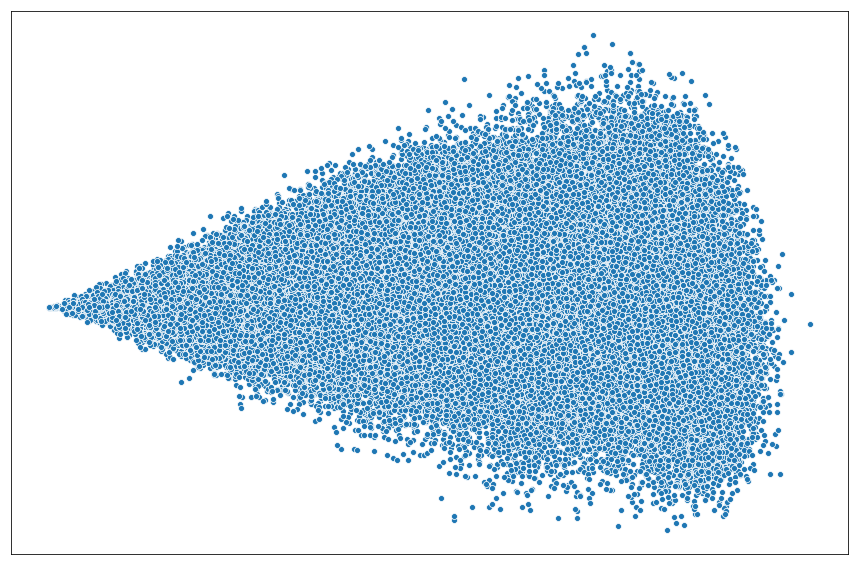

In [ ]:
n = elmo_df.shape[1] - 1
X = np.asarray(elmo_df.iloc[:, :n])
X_2d = PCA(n_components = 2).fit_transform(X)
elmo_2d = pd.DataFrame(X_2d, columns = ['x', 'y'])

fig, ax = plt.subplots(1, figsize = (15, 10))
ax.set_xticks([])
ax.set_yticks([])
sns.scatterplot(data = elmo_2d, x = 'x', y = 'y')

## One-hot encoding of categories

We then perform a one hot encoding for the category variable, as this will make training our model easier. We do this by first creating a dataframe with columns the categories and binary values for every paper, and then concatenate our original dataframe with the binary values.

In [5]:
# one-hot encode categories
onehot.one_hot(file_name, data_path)

# load data
print("Loading category data...")
full_path = os.path.join(data_path, f"{file_name}_1hot.csv")
df_1hot = pd.read_csv(full_path)
print(f"Category data loaded.")

# show the new columns of the data frame
pd.set_option('display.max_colwidth', 10)
print(f"Dimensions of df_1hot: {df_1hot.shape}.")
df_1hot.head()

File already one-hot encoded.
Loading category data...
Category data loaded.
Dimensions of df_1hot: (99998, 1177).


,0,1,2,3,4,5,6,7,8,9,...,q-fin.RM,q-fin.ST,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH
0,0.072748,0.263977,-0.019785,-0.060801,0.042781,-0.132526,-0.010097,0.261660,0.176735,-0.275321,...,0,0,0,0,0,0,0,0,0,0
1,0.007096,0.080332,-0.014846,-0.027352,0.067107,-0.074171,-0.001763,0.046547,0.042150,-0.101436,...,0,0,0,0,0,0,0,0,0,0
2,0.018126,-0.002957,0.063598,-0.033854,0.004734,0.021210,0.003202,0.133582,-0.004545,-0.170221,...,0,0,0,0,0,0,0,0,0,0
3,0.032250,0.110886,0.080280,-0.156859,0.034792,0.123132,-0.135968,0.464116,-0.015481,-0.145285,...,0,0,0,0,0,0,0,0,0,0
4,0.020333,-0.001389,-0.021313,-0.073311,-0.013130,-0.156879,0.029190,0.160236,-0.096619,-0.121133,...,0,1,0,0,0,0,0,0,0,0


## Analysis of the data

Here is how the categories in our data set are distributed.

In [10]:
# save a dataframe with the amount of papers in each category
sum_cats = df_1hot.iloc[:, 1024:].apply(lambda x: x.sum())

# get statistical information about the distribution of the amount of papers
sum_cats.describe()

count    153.00...
mean     1405.4...
std      1074.9...
min      31.000000
25%      525.00...
50%      1262.0...
75%      1947.0...
max      5117.0...
dtype: float64

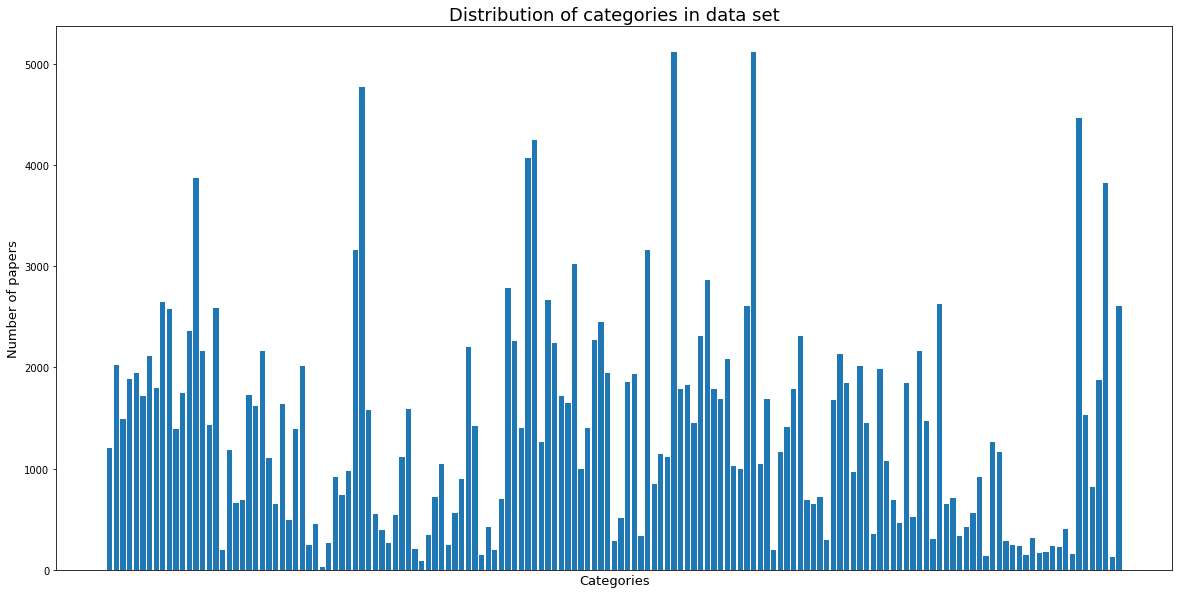

In [11]:
# plot the distribution of the amount of papers in each category
plt.figure(figsize = (20,10))
plt.bar(x = sum_cats.keys(), height = sum_cats.values)
plt.xlabel('Categories', fontsize = 13)
plt.ylabel('Number of papers', fontsize = 13)
plt.title('Distribution of categories in data set', fontsize = 18)
plt.xticks([])
plt.show()

We see that our data is not particularly uniformly distributed. These are the categories with the most amount of papers in the data set.

In [13]:
# add the counts to the dataframe and sort 
cats_df['count'] = sum_cats.values
cats_df = cats_df.sort_values(by=['count'], ascending = False)

pd.set_option('display.max_colwidth', 50)
cats_df[:5]

,category,description,count
88,math.OA,Operator Algebras,5117
99,nlin.CD,Chaotic Dynamics,5117
121,physics.med-ph,Medical Physics,4775
13,cond-mat.stat-mech,Statistical Mechanics,4463
94,math.SG,Symplectic Geometry,4252


## Building a model

We are now done manipulating our data, and the time has come to build a model.

In [13]:
# fetch data
full_path = os.path.join(data_path, f"{file_name}_1hot.csv")
df_1hot = pd.read_csv(full_path)
X = np.asarray(df_1hot.iloc[:, :1024])
y = np.asarray(df_1hot.iloc[:, 1024:])

full_path = os.path.join(data_path, f"{file_name}_model.pickle")
if os.path.isfile(full_path):
    with open(full_path, 'rb') as pickle_in:
        nn_model = pickle.load(pickle_in)
    print("Model already trained.")

else:
    # time training for good measure
    start_time = datetime.now()

    # build homegrown neural network
    nn_model = NeuralNetwork(
        layer_dims = [30, 5],
        activations = ['tanh', 'sigmoid']
        )

    # train/test split, for calculating test scores 
    #Xtrain, ytrain, Xtest, ytest = 

    # fit the neural network to X and initialise params
    nn_model.fit(X)

    # train the neural network
    nn_model.train(X, y)

    # save model
    full_path = os.path.join(data_path, f'{file_name}_model.pickle')
    with open(full_path, 'wb') as pickle_out:
        pickle.dump(nn_model, pickle_out)

    print("Training complete!")
    print(f"Time spent: {datetime.now() - start_time}")

Model already trained.


In [14]:
# calculate training accuracy
m = X.shape[1]
yhat = np.squeeze(np.around(nn_model.predict(X), decimals = 0)).astype('int')
correct_predictions = np.sum(np.asarray([reduce(lambda z, w: z and w, x) for x in np.equal(y.T, yhat.T)]))
train_accuracy = correct_predictions / m

print(f"Training accuracy: {np.around(train_accuracy * 100, 2)}%")

Training accuracy: 94.54%
